# Two Stage Robust Optimization with CCG Algorithm

This is a toy example impelementation for the paper [Solving two-stage robust optimization problems using a column-and-constraint generation method](https://doi.org/10.1016/j.orl.2013.05.003) 

In [1]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

In [ ]:
def generate_ccg_data(dimension, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    # Generate cost vector `f` (fixed cost for opening facilities)
    f = np.random.randint(300, 500, size=dimension)
    
    # Generate cost vector `a` (cost per unit capacity)
    a = np.random.randint(15, 30, size=dimension)
    
    # Generate matrix `c` (cost of assigning demand from facility i to customer j)
    c = np.random.randint(20, 35, size=(dimension, dimension))
    
    # Generate initial demand `init_d` for each customer
    init_d = np.random.randint(200, 300, size=dimension)
    
    # Set capacity
    capacity = 800
    
    # Return all generated data as a dictionary
    return {
        "f": f,
        "a": a,
        "c": c,
        "capacity": capacity,
        "init_d": init_d
    }

In [46]:
class CCG_toy:
    def __init__(self, f, a, c, capacity, init_d = None, M = 1e5, epsilon = 1e-5, max_iter=100, OutputFlag=0):
        self.f = f
        self.a = a
        self.c = c
        self.capacity = capacity
        self.d = []
        self.init_d = init_d

        self.n = self.c.shape[0]
        self.m = self.c.shape[1]

        self.UB = float("inf")
        self.LB = float("-inf")
        self.M = M
        self.epsilon = epsilon
        self.k = 0
        self.max_iter = max_iter
        self.lb_set = []
        self.ub_set = []

        self.OutputFlag = OutputFlag

        self.initialize_model()

    def initialize_model(self):
        
        # Master problem
        self.MP = gp.Model("CC&G Master")
        self.y = self.MP.addVars(range(self.n), vtype=gp.GRB.BINARY, name="y")
        self.z = self.MP.addVars(range(self.n), lb=0, vtype=gp.GRB.CONTINUOUS, name="z")
        self.x_SP = self.MP.addVars(range(self.n), range(self.m), lb=0, vtype=gp.GRB.CONTINUOUS, name="x_SP")
        self.yita = self.MP.addVar(vtype=gp.GRB.CONTINUOUS, name="yita")
        
        self.MP_Obj = gp.quicksum(self.f[i] * self.y[i] + self.a[i] * self.z[i] for i in range(self.n))
        self.MP_Obj = self.MP_Obj + self.yita
        self.MP.setObjective(self.MP_Obj, gp.GRB.MINIMIZE)
        
        self.MP.addConstrs((self.z[i] <= self.capacity*self.y[i] for i in range(self.n)), "z(i) <= 800*y(i)")
        self.MP.addConstr(sum(self.z[i] for i in range(self.n)) >= 772, "sum_z >= 772")
        for i in range(self.n):
            row_sum_x = sum(self.x_SP[i,j] for j in range(self.m))
            self.MP.addConstr(row_sum_x <= self.z[i], name=f"sum_x_{i} <= z{i}")
        if self.init_d is not None:
            for j in range(self.m):
                col_sum_x = sum(self.x_SP[i,j] for i in range(self.n))
                #self.MP.addConstr(col_sum_x >= self.init_d[j], name=f"sum_x_{j} >= opt_d{j}")
        
        # Adversarial problem
        self.SP = gp.Model("CC&G Sub")
        self.x = self.SP.addVars(range(self.n), range(self.m), lb=0, ub=gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="x")
        self.g = self.SP.addVars(range(self.n), lb=0, ub=1, vtype=gp.GRB.CONTINUOUS, name="g")
        self.d = self.SP.addVars(range(self.m), lb=0, ub=gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="d")
        
        if self.init_d is not None:
            self.SP.addConstrs(self.d[j] == self.init_d[j] + 40 * self.g[j] for j in range(self.m))

        self.SP.addConstr(sum(self.g[i] for i in range(self.n)) <= 3)
        #self.SP.addConstr(sum(self.g[i] for i in range(self.n)) <= 1.8)
        #self.SP.addConstr(self.g[0] + self.g[1] <= 1.2)

    def solve_master(self):
        if self.OutputFlag:
            print("---------------------")
            print(f"       MP {self.k}          ")
            print("---------------------")
        # Solve the master problem
        self.MP.optimize()
        # Get the optimal value of z
        z_opt = np.array([self.z[i].X for i in range(self.n)])
        # Update the lower bound
        self.LB = max(self.LB,self.MP.objVal)
        self.lb_set.append(self.LB)
        return z_opt
        
    def solve_subproblem(self, z_opt):
        if self.OutputFlag:
            print("---------------------")
            print(f"       SP {self.k}          ")
            print("---------------------")

        # Set subproblem constraints and objective
        if self.k > 0:
            for sp in self.sp_constraints:
                self.SP.remove(sp)
            for v in self.sp_variables:
                self.SP.remove(v)
            self.SP.update()

        # KKT constraints
        pi = self.SP.addVars(range(self.n), lb=-gp.GRB.INFINITY, ub=0, vtype=gp.GRB.CONTINUOUS, name="pi")
        theta = self.SP.addVars(range(self.m), lb=-gp.GRB.INFINITY, ub=0, vtype=gp.GRB.CONTINUOUS, name="theta")
        v = self.SP.addVars(range(self.n), vtype=gp.GRB.BINARY, name="v")
        w = self.SP.addVars(range(self.m), vtype=gp.GRB.BINARY, name="w")
        h = self.SP.addVars(range(self.n), range(self.m), vtype=gp.GRB.BINARY, name="h")
        self.sp_variables = [pi, theta, v, w, h]
        
        sp1 = self.SP.addConstrs(sum(self.x[i,j] for j in range(self.m)) <= z_opt[i] for i in range(self.n))
        sp2 = self.SP.addConstrs(sum(self.x[i,j] for i in range(self.n)) >= self.d[j] for j in range(self.m))
        sp3 = self.SP.addConstrs(pi[i] - theta[j] <= self.c[i][j] for i in range(self.n) for j in range(self.m))
        sp4 = self.SP.addConstrs(-pi[i] <= self.M*v[i] for i in range(self.n))
        sp5 = self.SP.addConstrs(z_opt[i] - sum(self.x[i,j] for j in range(self.m)) <= self.M*(1-v[i]) for i in range(self.n) for j in range(self.m))
        sp6 = self.SP.addConstrs(-theta[j] <= self.M*w[j] for j in range(self.m))
        sp7 = self.SP.addConstrs(sum(self.x[i,j] for i in range(self.n)) - self.d[j] <= self.M*(1-w[j]) for j in range(self.m))
        sp8 = self.SP.addConstrs(self.x[i,j] <= self.M*h[i,j] for i in range(self.n) for j in range(self.m))
        sp9 = self.SP.addConstrs(self.c[i][j] - pi[i] + theta[j] <= self.M*(1-h[i,j]) for i in range(self.n) for j in range(self.m))
        self.sp_constraints = [sp1, sp2, sp3, sp4, sp5, sp6, sp7, sp8, sp9]
   
        SP_Obj = sum(self.c[i][j]*self.x[i,j] for i in range(self.n) for j in range(self.m))
        self.SP.setObjective(SP_Obj, gp.GRB.MAXIMIZE)
            
        self.SP.optimize()

    def plot_results(self):
        plt.figure()
        plt.plot(range(self.k), self.lb_set, label="lower bound")
        plt.plot(range(self.k), self.ub_set, label="upper bound")
        plt.xlabel("iteration")
        plt.ylabel("value")
        plt.legend()
        plt.show()

    def optimize(self):
        print("Starting optimization")
        self.MP.Params.OutputFlag = self.OutputFlag
        self.SP.Params.OutputFlag = self.OutputFlag
        while (self.UB - self.LB > self.epsilon):
            print(f"Iteration {self.k} with UB: {self.UB} and LB: {self.LB}")
            z_opt = self.solve_master()
            self.solve_subproblem(z_opt)

            if self.SP.Status != gp.GRB.INFEASIBLE:
                opt_d = np.array([self.d[j].X for j in range(self.m)])
                y_stage1 = np.array([self.y[i].X for i in range(self.n)])
                z_stage1 = np.array([self.z[i].X for i in range(self.n)])
                    
            if self.SP.status == gp.GRB.OPTIMAL:
                # Update the upper bound
                self.UB = min(self.UB,self.SP.ObjVal + sum(self.f[i]*y_stage1[i] + self.a[i]*z_stage1[i] for i in range(self.n)))
                self.ub_set.append(self.UB)
                    
                var_name = f'x{self.k}'
                new_x = self.MP.addVars(range(self.n), range(self.m), lb=0, vtype=gp.GRB.CONTINUOUS, name=var_name)
                    
                sum_cx = 0
                for i in range(self.n):
                    for j in range(self.m):
                        sum_cx += self.c[i,j]*new_x[i,j]
                self.MP.addConstr(self.yita >= sum_cx, name="yita >= sum_cx")
                    
                for i in range(self.n):
                    row_sum_x = sum(new_x[i,j] for j in range(self.m))
                    self.MP.addConstr(row_sum_x <= self.z[i], name=f"sum_x_{i} <= z{i}")
                    
                for j in range(self.m):
                    col_sum_x = sum(new_x[i,j] for i in range(self.n))
                    self.MP.addConstr(col_sum_x >= opt_d[j], name=f"sum_x_{j} >= opt_d{j}")
                    
                self.MP.update()
                    
            elif self.SP.Status == gp.GRB.UNBOUNDED:
                # Update the upper bound
                self.UB = min(self.UB, self.SP.ObjVal)
                self.ub_set.append(self.UB)
                    
                var_name = f'x{self.k}'
                self.MP.addVars(range(self.n), range(self.m), lb=0, vtype=gp.GRB.CONTINUOUS, name=var_name)
                    
                for i in range(self.n):
                    row_sum_x = sum(new_x[i,j] for j in range(self.m))
                    self.MP.addConstr(row_sum_x <= self.z[i], name=f"sum_x_{i} <= z{i}")
                    
                for j in range(self.m):
                    col_sum_x = sum(new_x[i,j] for i in range(self.n))
                    self.MP.addConstr(col_sum_x >= opt_d[j], name=f"sum_x_{j} >= opt_d{j}")
                
            else:
                print("No solution due to infeasibility")
                break

            if self.k > self.max_iter:
                break
            self.k = self.k + 1

        print(f"Optimization complete in {self.k} iterations. UB: {self.UB}, LB: {self.LB}")
        self.plot_results()

Starting optimization
Iteration 0 with UB: inf and LB: -inf
Iteration 1 with UB: 39772.0 and LB: 14296.0
Iteration 2 with UB: 36610.0 and LB: 35066.0
Optimization complete in 3 iterations. UB: 36308.181818181816, LB: 36308.18181818182


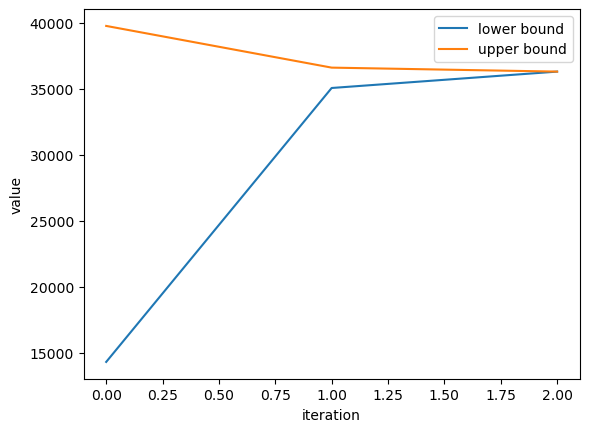

In [25]:
f = np.array([400,414,326])
a = np.array([18,25,20])
c = np.array([[22,33,24],
              [33,23,30],
              [20,25,27]])
capacity = 800
init_d = np.array([206,274,220])

ccg = CCG_toy(f, a, c, capacity)
ccg.optimize()

Starting optimization
Iteration 0 with UB: inf and LB: -inf
Iteration 1 with UB: 38148.0 and LB: 11900.0
Iteration 2 with UB: 38148.0 and LB: 34374.0
Iteration 3 with UB: 38148.0 and LB: 36139.352941176476
Iteration 4 with UB: 38148.0 and LB: 36482.0
Iteration 5 with UB: 38148.0 and LB: 36670.30769230769
Iteration 6 with UB: 38148.0 and LB: 36978.0
Optimization complete in 7 iterations. UB: 37048.833333333336, LB: 37048.833333333336


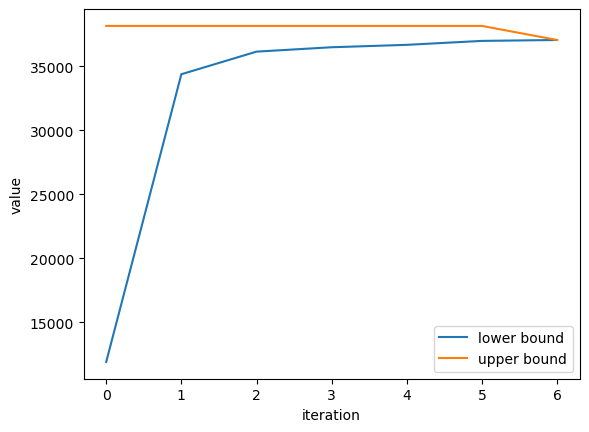

In [47]:
data = generate_ccg_data(dimension=20, seed=42)

f, a, c, capacity, init_d = data["f"], data["a"], data["c"], data["capacity"], data["init_d"]
ccg = CCG_toy(f, a, c, capacity)
ccg.optimize()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gurobipy as gp

class NNCROWN2StageRO:
    def __init__(self, f, a, c, capacity, init_d, eta=0.01, epsilon=1e-5, max_iter=100, OutputFlag=0):
        self.f = f
        self.a = a
        self.c = c
        self.capacity = capacity
        self.init_d = init_d

        self.n = len(f)  # Number of facilities
        self.m = len(init_d)  # Number of customers

        self.epsilon = epsilon
        self.eta = eta
        self.max_iter = max_iter
        self.OutputFlag = OutputFlag

        self.k = 0  # Iteration counter
        self.scenarios = [init_d]  # Initialize with the first scenario
        self.lb_set = []
        self.ub_set = []

        # Initialize Neural Network
        self.model = self.build_nn()
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.eta)

        self.initialize_model()

    def build_nn(self):
        """Define a simple feedforward neural network."""
        return nn.Sequential(
            nn.Linear(self.m, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: predicted cost
        )

    def initialize_model(self):
        """Initialize the master problem."""
        self.MP = gp.Model("Master Problem")
        self.y = self.MP.addVars(range(self.n), vtype=gp.GRB.BINARY, name="y")
        self.z = self.MP.addVars(range(self.n), lb=0, vtype=gp.GRB.CONTINUOUS, name="z")
        self.x = self.MP.addVars(range(self.n), range(self.m), lb=0, vtype=gp.GRB.CONTINUOUS, name="x")
        self.tau = self.MP.addVar(vtype=gp.GRB.CONTINUOUS, name="tau")
        
        # Objective: Fixed + variable costs + worst-case cost
        self.MP.setObjective(
            gp.quicksum(self.f[i] * self.y[i] + self.a[i] * self.z[i] for i in range(self.n)) + self.tau,
            gp.GRB.MINIMIZE
        )
        
        # Constraints
        self.MP.addConstrs((self.z[i] <= self.capacity * self.y[i] for i in range(self.n)), name="Capacity")
        self.MP.addConstr(sum(self.z[i] for i in range(self.n)) >= 772, name="TotalCapacity")

        for scenario in self.scenarios:
            self.add_scenario_constraints(scenario)

    def add_scenario_constraints(self, scenario):
        """Add constraints for a specific scenario."""
        for i in range(self.n):
            self.MP.addConstr(
                gp.quicksum(self.x[i, j] for j in range(self.m)) <= self.z[i],
                name=f"Supply_{i}_Scenario_{len(self.scenarios)}"
            )
        for j in range(self.m):
            self.MP.addConstr(
                gp.quicksum(self.x[i, j] for i in range(self.n)) >= scenario[j],
                name=f"Demand_{j}_Scenario_{len(self.scenarios)}"
            )
        self.MP.addConstr(
            self.tau >= gp.quicksum(self.c[i][j] * self.x[i, j] for i in range(self.n) for j in range(self.m)),
            name=f"WorstCaseCost_Scenario_{len(self.scenarios)}"
        )

    def solve_master_problem(self):
        """Solve the master problem and return the current decision variables."""
        self.MP.optimize()
        if self.MP.Status == gp.GRB.OPTIMAL:
            z_opt = np.array([self.z[i].X for i in range(self.n)])
            tau = self.tau.X
            mp_obj = self.MP.objVal
            return z_opt, tau, mp_obj
        else:
            raise Exception("Master Problem is infeasible or unbounded.")

    def train_nn(self, train_data):
        """Train the neural network on the given data."""
        self.model.train()
        inputs, targets = train_data
        inputs = torch.tensor(inputs, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32).view(-1, 1)
        
        # Forward pass
        predictions = self.model(inputs)
        loss = self.loss_fn(predictions, targets)

        # Backward pass and optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def attack(self):
        """Simulate adversarial attack to find the worst-case scenario."""
        self.model.eval()
        with torch.no_grad():
            worst_case = self.init_d + np.random.uniform(-20, 20, size=self.m)  # Example perturbation
            return worst_case

    def verify(self):
        """Verify the robustness of the solution."""
        for scenario in self.scenarios:
            if np.any(scenario < self.init_d - 20) or np.any(scenario > self.init_d + 20):
                return False
        return True

    def optimize(self):
        """Run the NN-CROWN 2 Stage RO algorithm."""
        self.MP.Params.OutputFlag = 0
        train_data = ([], [])  # Collect data for training: (inputs, targets)

        while self.k < self.max_iter:
            print(f"Iteration {self.k}")

            # Step 1: Solve the master problem
            z_opt, tau, mp_obj = self.solve_master_problem()
            print(f"Master Problem Objective: {mp_obj}")
            #print(f"Master Problem Solution: z_opt = {z_opt}, tau = {tau}")

            # Collect training data
            train_data[0].append(self.init_d)
            train_data[1].append(tau)

            # Step 2: Train the neural network
            if self.k > 0:  # Train only after collecting data
                self.train_nn((train_data[0], train_data[1]))

            # Step 3: Identify the worst-case scenario
            new_scenario = self.attack()
            if np.all(new_scenario == self.init_d):  # Simulated termination condition
                if self.verify():
                    print("All scenarios verified. Algorithm converged.")
                    break
                else:
                    print("Verification failed. Algorithm continues.")
            else:
                self.scenarios.append(new_scenario)
                self.add_scenario_constraints(new_scenario)
                #print(f"New scenario added: {new_scenario}")

            self.k += 1

        print("Optimization complete.")

In [57]:
nncrown = NNCROWN2StageRO(f, a, c, capacity, init_d, eta=0.01, max_iter=10, OutputFlag=1)
nncrown.optimize()

Iteration 0
Master Problem Objective: 31832.0
Iteration 1
Master Problem Objective: 32049.046661975848
Iteration 2
Master Problem Objective: 32337.97845750453
Iteration 3
Master Problem Objective: 32640.80759695678
Iteration 4
Master Problem Objective: 33070.16623124529
Iteration 5
Master Problem Objective: 33214.6103152339
Iteration 6
Master Problem Objective: 33214.6103152339
Iteration 7
Master Problem Objective: 33214.6103152339
Iteration 8
Master Problem Objective: 33214.6103152339
Iteration 9
Master Problem Objective: 33214.6103152339
Optimization complete.
